In [3]:
import numpy as np
import pandas as pd
import warnings
warnings.simplefilter('ignore')
import math
from statistics import mean
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import timedelta
from sklearn.metrics import mean_squared_error


#from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout
from tensorflow.keras.layers import LSTM
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model

In [4]:
status_df = pd.read_csv("dataset/status.csv")
status_df.head()

,id,year,month,day,hour,station_id,bikes_available,predict
0,0,2013,9,1,0,0,11.0,0
1,1,2013,9,1,1,0,11.0,0
2,2,2013,9,1,2,0,11.0,0
3,3,2013,9,1,3,0,11.0,0
4,4,2013,9,1,4,0,11.0,0


In [5]:
#曜日を追加するための関数を定義
def get_weekday_jp(dt):
    w_list = ['月曜日', '火曜日', '水曜日', '木曜日', '金曜日', '土曜日', '日曜日']
    return(w_list[dt.weekday()])

#year, month, dayを結合してdatetime型に変換
status_df["date"] = status_df["year"].astype(str) + status_df["month"].astype(str).str.zfill(2) + status_df["day"].astype(str).str.zfill(2)
status_df["date"] = pd.to_datetime(status_df["date"])
#dateから曜日情報を取得
status_df["weekday"] = status_df["date"].apply(get_weekday_jp)
status_df.head(10)

,id,year,month,day,hour,station_id,bikes_available,predict,date,weekday
0,0,2013,9,1,0,0,11.0,0,2013-09-01,日曜日
1,1,2013,9,1,1,0,11.0,0,2013-09-01,日曜日
2,2,2013,9,1,2,0,11.0,0,2013-09-01,日曜日
3,3,2013,9,1,3,0,11.0,0,2013-09-01,日曜日
4,4,2013,9,1,4,0,11.0,0,2013-09-01,日曜日
5,5,2013,9,1,5,0,11.0,0,2013-09-01,日曜日
6,6,2013,9,1,6,0,11.0,0,2013-09-01,日曜日
7,7,2013,9,1,7,0,11.0,0,2013-09-01,日曜日
8,8,2013,9,1,8,0,11.0,0,2013-09-01,日曜日
9,9,2013,9,1,9,0,11.0,0,2013-09-01,日曜日


In [6]:
status_df[status_df["predict"]==1].head()

,id,year,month,day,hour,station_id,bikes_available,predict,date,weekday
8761,8761,2014,9,1,1,0,NaN,1,2014-09-01,月曜日
8762,8762,2014,9,1,2,0,NaN,1,2014-09-01,月曜日
8763,8763,2014,9,1,3,0,NaN,1,2014-09-01,月曜日
8764,8764,2014,9,1,4,0,NaN,1,2014-09-01,月曜日
8765,8765,2014,9,1,5,0,NaN,1,2014-09-01,月曜日


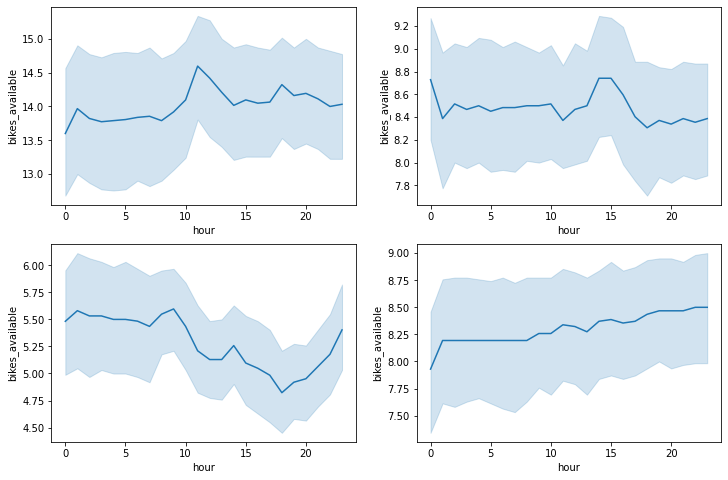

In [7]:
#bikes_availableの変動を可視化する
plt.figure(figsize=(12,8))
for i in range(4):
    plt.subplot(2,2,i+1)
    plot_df = status_df[(status_df["weekday"]=="土曜日")&(status_df["station_id"]==i)]
    sns.lineplot(x ='hour', y ='bikes_available',data = plot_df)

In [8]:
#これから細かい前処理をするためにmain_dfを作成
main_df = status_df[["date","hour","station_id","bikes_available","weekday","predict"]]
main_df.head()

,date,hour,station_id,bikes_available,weekday,predict
0,2013-09-01,0,0,11.0,日曜日,0
1,2013-09-01,1,0,11.0,日曜日,0
2,2013-09-01,2,0,11.0,日曜日,0
3,2013-09-01,3,0,11.0,日曜日,0
4,2013-09-01,4,0,11.0,日曜日,0


In [9]:
#カテゴリ変数をダミー変数化
main_df = pd.get_dummies(main_df)
print(main_df.columns)
print(main_df.shape)

Index(['date', 'hour', 'station_id', 'bikes_available', 'predict',
       'weekday_土曜日', 'weekday_日曜日', 'weekday_月曜日', 'weekday_木曜日',
       'weekday_水曜日', 'weekday_火曜日', 'weekday_金曜日'],
      dtype='object')
(1226400, 12)


In [10]:
#学習用のデータフレームを作成
train_dataset_df = main_df[main_df["date"]<"2014-09-01"]
#評価用のデータフレームを作成(使用するモデルの関係上、前日のデータが必要なため2014-08-31から取得)
evaluation_dataset_df = main_df[main_df["date"]>="2014-08-31"]

In [11]:
#学習用データの欠損値を確認
print(train_dataset_df.isnull().sum())

date                   0
hour                   0
station_id             0
bikes_available    21605
predict                0
weekday_土曜日            0
weekday_日曜日            0
weekday_月曜日            0
weekday_木曜日            0
weekday_水曜日            0
weekday_火曜日            0
weekday_金曜日            0
dtype: int64


In [12]:
train_dataset_df[train_dataset_df["bikes_available"].isnull()].head()

,date,hour,station_id,bikes_available,predict,weekday_土曜日,weekday_日曜日,weekday_月曜日,weekday_木曜日,weekday_水曜日,weekday_火曜日,weekday_金曜日
420480,2013-09-01,0,24,NaN,0,0,1,0,0,0,0,0
420481,2013-09-01,1,24,NaN,0,0,1,0,0,0,0,0
420482,2013-09-01,2,24,NaN,0,0,1,0,0,0,0,0
420483,2013-09-01,3,24,NaN,0,0,1,0,0,0,0,0
420484,2013-09-01,4,24,NaN,0,0,1,0,0,0,0,0


In [13]:
train_dataset_df[train_dataset_df["bikes_available"].isnull()].tail()

,date,hour,station_id,bikes_available,predict,weekday_土曜日,weekday_日曜日,weekday_月曜日,weekday_木曜日,weekday_水曜日,weekday_火曜日,weekday_金曜日
1214167,2014-04-09,7,69,NaN,0,0,0,0,0,1,0,0
1214168,2014-04-09,8,69,NaN,0,0,0,0,0,1,0,0
1214169,2014-04-09,9,69,NaN,0,0,0,0,0,1,0,0
1214170,2014-04-09,10,69,NaN,0,0,0,0,0,1,0,0
1214171,2014-04-09,11,69,NaN,0,0,0,0,0,1,0,0


In [14]:
#各ステーション毎に、欠損値を後の値で埋める
train_dataset_df_new = pd.DataFrame()
for station_id in train_dataset_df["station_id"].unique().tolist():
    temp_df = train_dataset_df[train_dataset_df["station_id"]==station_id]
    temp_df = temp_df.fillna(method="bfill")
    train_dataset_df_new = pd.concat([train_dataset_df_new,temp_df])

print(train_dataset_df_new.isnull().sum())

date               0
hour               0
station_id         0
bikes_available    0
predict            0
weekday_土曜日        0
weekday_日曜日        0
weekday_月曜日        0
weekday_木曜日        0
weekday_水曜日        0
weekday_火曜日        0
weekday_金曜日        0
dtype: int64


In [15]:
temp_df#データセットを時系列に並び替える(後ほど説明)
train_df = train_dataset_df_new.sort_values(["date","hour","station_id"],ascending=True).reset_index(drop=True)
evaluation_dataset_df = evaluation_dataset_df.sort_values(["date","hour","station_id"],ascending=True).reset_index(drop=True)
#学習用データセット
train_df.head()

,date,hour,station_id,bikes_available,predict,weekday_土曜日,weekday_日曜日,weekday_月曜日,weekday_木曜日,weekday_水曜日,weekday_火曜日,weekday_金曜日
0,2013-09-01,0,0,11.0,0,0,1,0,0,0,0,0
1,2013-09-01,0,1,8.0,0,0,1,0,0,0,0,0
2,2013-09-01,0,2,5.0,0,0,1,0,0,0,0,0
3,2013-09-01,0,3,9.0,0,0,1,0,0,0,0,0
4,2013-09-01,0,4,8.0,0,0,1,0,0,0,0,0


In [14]:
#predictは特徴量として必要ないため、削除
train_df = train_df.drop("predict",axis=1)
train_df.head()

,date,hour,station_id,bikes_available,weekday_土曜日,weekday_日曜日,weekday_月曜日,weekday_木曜日,weekday_水曜日,weekday_火曜日,weekday_金曜日
0,2013-09-01,0,0,11.0,0,1,0,0,0,0,0
1,2013-09-01,0,1,8.0,0,1,0,0,0,0,0
2,2013-09-01,0,2,5.0,0,1,0,0,0,0,0
3,2013-09-01,0,3,9.0,0,1,0,0,0,0,0
4,2013-09-01,0,4,8.0,0,1,0,0,0,0,0


In [15]:
#今回LSTMモデルを使用するため、データを標準化
#特徴量を標準化するための変数
scaler = MinMaxScaler(feature_range=(0, 1))
#標準化された出力をもとにスケールに変換(inverse)するために必要な変数
scaler_for_inverse = MinMaxScaler(feature_range=(0, 1))
train_df_scale = scaler.fit_transform(train_df.iloc[:,3:])
bikes_available_scale = scaler_for_inverse.fit_transform(train_df[["bikes_available"]])
print(train_df_scale.shape)

(613200, 8)


In [16]:
train_df_scale[0]

array([0.40740741, 0.        , 1.        , 0.        , 0.        ,
       0.        , 0.        , 0.        ])

In [17]:
#学習用のデータをモデルの学習用とモデルの精度の検証用に分割
#今回は、モデル用学習データ:精度用の検証データ = 8 : 2 に分割
length = len(train_df_scale)
train_size = int(length * 0.8)
test_size = length - train_size
train, test = train_df_scale[0:train_size,:], train_df_scale[train_size:length,:]
print(train.shape)
print(test.shape)

(490560, 8)
(122640, 8)


In [18]:
train

array([[0.40740741, 0.        , 1.        , ..., 0.        , 0.        ,
        0.        ],
       [0.2962963 , 0.        , 1.        , ..., 0.        , 0.        ,
        0.        ],
       [0.18518519, 0.        , 1.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.07407407, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.2962963 , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.37037037, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [19]:
def create_dataset(dataset):
    dataX = []
    dataY = np.array([])
    #1680で1つのデータセットであるため、余りの分は使わない
    extra_num = len(dataset) % 70
    max_len = len(dataset)-extra_num
    for i in range(1680,max_len,70):
        xset = []
        for j in range(dataset.shape[1]):
            a = dataset[i-1680:i, j]
            xset.append(a)
        temp_array = np.array(dataset[i:i+70,0])
        dataY = np.concatenate([dataY,temp_array])
        dataX.append(xset)
    dataY = dataY.reshape(-1,70)
    return np.array(dataX), dataY 

In [20]:
trainX, trainY = create_dataset(train)
testX, testY = create_dataset(test)
#LSTMのモデルに入力用にデータの形を整形
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], trainX.shape[2]))
testX = np.reshape(testX, (testX.shape[0], testX.shape[1], testX.shape[2]))
#入力データと正解データの形を確認
print(trainX.shape)
print(trainY.shape)

(6984, 8, 1680)
(6984, 70)


In [21]:
model = Sequential()
model.add(LSTM(50, input_shape=(trainX.shape[1],1680)))
model.add(Dense(70))
model.compile(loss='mean_squared_error', optimizer='adam')

2021-10-21 23:56:58.843154: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [22]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 50)                346200    
_________________________________________________________________
dense (Dense)                (None, 70)                3570      
Total params: 349,770
Trainable params: 349,770
Non-trainable params: 0
_________________________________________________________________


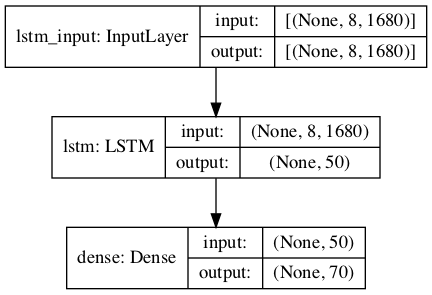

In [23]:
plot_model(
    model,
    show_shapes=True,
)

In [24]:
hist = model.fit(trainX, trainY, epochs=20, batch_size=1, verbose=2)

2021-10-21 23:57:00.501671: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/20
6984/6984 - 35s - loss: 0.0130
Epoch 2/20


KeyboardInterrupt: 

In [ ]:
#学習済みモデルで予測
train_predict = model.predict(trainX)
test_predict = model.predict(testX)

#スケールをもとに戻す
train_predict = scaler_for_inverse.inverse_transform(train_predict)
trainY = scaler_for_inverse.inverse_transform(trainY)
test_predict = scaler_for_inverse.inverse_transform(test_predict)
testY = scaler_for_inverse.inverse_transform(testY)

#各ステーションのスコアの平均値を算出
train_score_list = []
test_score_list = []
for i in range(70):
    trainscore = math.sqrt(mean_squared_error(trainY[:,i], train_predict[:,i]))
    train_score_list.append(trainscore)
    testscore = math.sqrt(mean_squared_error(testY[:,i], test_predict[:,i]))
    test_score_list.append(testscore)
    
print("trainのRMSE平均 : ",mean(train_score_list))
print("testのRMSE平均 : ",mean(test_score_list))

In [16]:
#予測日とその前日を含むデータフレームを作成すると前日の日付データを返す関数
def make_sameday_thedaybefore_dataset(dataset,prediction_date):
    #前日の日付をtimedeltaで取得
    before_date = prediction_date - timedelta(days=1)
    prediction_date = str(prediction_date).split(" ")[0]
    before_date = str(before_date).split(" ")[0]
    #予測日とその前日を含むものだけを抽出
    temp_dataset = dataset[dataset["date"].isin([before_date,prediction_date])]
        
    return before_date,temp_dataset


#評価用のデータセットを作成する関数
def make_evaluation_dataset(dataset):
    output_df = pd.DataFrame()
    prediction_date_list = dataset[dataset["predict"]==1]["date"].tolist()
    for date in sorted(list(set(prediction_date_list))):
        before_date,temp_dataset = make_sameday_thedaybefore_dataset(dataset,date)
        #前日のbikes_availableに欠損値が含まれるかどうかの判定
        if temp_dataset[temp_dataset["date"]==before_date]["bikes_available"][1:].isnull().any(): 
            #各ステーションで予測日の０時で前日の1時以降のデータを置換
            #予測日のbikes_availableの置換は、後ほど別途処理するので今回は無視
            temp_dataset = temp_dataset.sort_values(["station_id","date","hour"]).fillna(method="bfill")
            temp_dataset = temp_dataset.sort_values(["date","hour","station_id"],ascending=True)
            #予測には、前日の1時からのデータしか使用しないので、0時のデータは除く
            output_df = pd.concat([output_df,temp_dataset.iloc[70:,:]])
        else: #欠損値なし　→ そのまま前日分のデータを利用
            output_df = pd.concat([output_df,temp_dataset.iloc[70:,:]])
        
    return output_df

In [17]:
evaluation_dataset_df.head()

,date,hour,station_id,bikes_available,predict,weekday_土曜日,weekday_日曜日,weekday_月曜日,weekday_木曜日,weekday_水曜日,weekday_火曜日,weekday_金曜日
0,2014-08-31,0,0,11.0,0,0,1,0,0,0,0,0
1,2014-08-31,0,1,9.0,0,0,1,0,0,0,0,0
2,2014-08-31,0,2,4.0,0,0,1,0,0,0,0,0
3,2014-08-31,0,3,8.0,0,0,1,0,0,0,0,0
4,2014-08-31,0,4,7.0,0,0,1,0,0,0,0,0


In [18]:
evaluation_df = make_evaluation_dataset(evaluation_dataset_df)
evaluation_df.head()
# evaluation_df.tail()

,date,hour,station_id,bikes_available,predict,weekday_土曜日,weekday_日曜日,weekday_月曜日,weekday_木曜日,weekday_水曜日,weekday_火曜日,weekday_金曜日
70,2014-08-31,1,0,11.0,0,0,1,0,0,0,0,0
71,2014-08-31,1,1,9.0,0,0,1,0,0,0,0,0
72,2014-08-31,1,2,4.0,0,0,1,0,0,0,0,0
73,2014-08-31,1,3,8.0,0,0,1,0,0,0,0,0
74,2014-08-31,1,4,7.0,0,0,1,0,0,0,0,0


In [34]:
#LSTMの出力結果でデータを補完しながら、提出用データフレームを作成する関数
def predict_eva_dataset(eva_dataset):
    submission_df = pd.DataFrame()
    #予測したbikes_availableを元のスケールに戻すための変数
    scaler_for_inverse = MinMaxScaler(feature_range=(0, 1))
    scale_y = scaler_for_inverse.fit_transform(eva_dataset[["bikes_available"]])
    prediction_date_list = eva_dataset[eva_dataset["predict"]==1]["date"].tolist()
    print(prediction_date_list[0:40])
    for date in sorted(list(set(prediction_date_list))):
        before_date, temp_eva_dataset = make_sameday_thedaybefore_dataset(eva_dataset,date)
        for i in range(0,1610,70):
            #モデルに入れるためのデータセット(1680×columns)
            temp_eva_dataset_train = temp_eva_dataset.iloc[i:1680+i,:]
            #predictは特徴量に使わないため、ここで削除
            temp_eva_dataset_train = temp_eva_dataset_train.drop("predict",axis=1)
            #データを標準化する
            scaler = MinMaxScaler(feature_range=(0, 1))
            temp_eva_dataset_scale = scaler.fit_transform(temp_eva_dataset_train.iloc[:,3:])
            
            #モデルに入力する形にデータを整形
            train = []
            xset = []
            for j in range(temp_eva_dataset_scale.shape[1]):
                a = temp_eva_dataset_scale[:, j]
                xset.append(a)
            train.append(xset)
            train = np.array(train)
            train = np.reshape(train, (train.shape[0], train.shape[1], train.shape[2]))
            
            #学習済みlstmモデルで予測
            #predict_scale = model.predict(train)
            #predict = scaler_for_inverse.inverse_transform(predict_scale)

            #次に使うbikes_availableに出力結果を補完
            #temp_eva_dataset.iloc[1680+i:1750+i,3] = predict[0]

        submission_df= pd.concat([submission_df,temp_eva_dataset.iloc[1610:,:]])
        
    return submission_df

In [35]:
evaluation_df

,date,hour,station_id,bikes_available,predict,weekday_土曜日,weekday_日曜日,weekday_月曜日,weekday_木曜日,weekday_水曜日,weekday_火曜日,weekday_金曜日
70,2014-08-31,1,0,11.0,0,0,1,0,0,0,0,0
71,2014-08-31,1,1,9.0,0,0,1,0,0,0,0,0
72,2014-08-31,1,2,4.0,0,0,1,0,0,0,0,0
73,2014-08-31,1,3,8.0,0,0,1,0,0,0,0,0
74,2014-08-31,1,4,7.0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
611515,2015-08-29,23,65,NaN,1,1,0,0,0,0,0,0
611516,2015-08-29,23,66,NaN,1,1,0,0,0,0,0,0
611517,2015-08-29,23,67,NaN,1,1,0,0,0,0,0,0
611518,2015-08-29,23,68,NaN,1,1,0,0,0,0,0,0


[Timestamp('2014-09-01 00:00:00'), Timestamp('2014-09-01 00:00:00'), Timestamp('2014-09-01 00:00:00'), Timestamp('2014-09-01 00:00:00'), Timestamp('2014-09-01 00:00:00'), Timestamp('2014-09-01 00:00:00'), Timestamp('2014-09-01 00:00:00'), Timestamp('2014-09-01 00:00:00'), Timestamp('2014-09-01 00:00:00'), Timestamp('2014-09-01 00:00:00'), Timestamp('2014-09-01 00:00:00'), Timestamp('2014-09-01 00:00:00'), Timestamp('2014-09-01 00:00:00'), Timestamp('2014-09-01 00:00:00'), Timestamp('2014-09-01 00:00:00'), Timestamp('2014-09-01 00:00:00'), Timestamp('2014-09-01 00:00:00'), Timestamp('2014-09-01 00:00:00'), Timestamp('2014-09-01 00:00:00'), Timestamp('2014-09-01 00:00:00'), Timestamp('2014-09-01 00:00:00'), Timestamp('2014-09-01 00:00:00'), Timestamp('2014-09-01 00:00:00'), Timestamp('2014-09-01 00:00:00'), Timestamp('2014-09-01 00:00:00'), Timestamp('2014-09-01 00:00:00'), Timestamp('2014-09-01 00:00:00'), Timestamp('2014-09-01 00:00:00'), Timestamp('2014-09-01 00:00:00'), Timestamp('20

<AxesSubplot:xlabel='date', ylabel='bikes_available'>

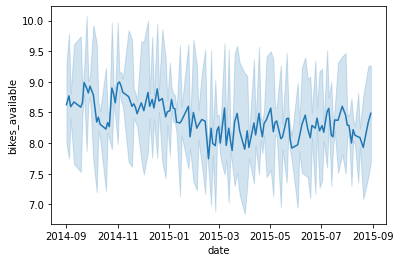

In [36]:
#予測した結果を時系列で可視化して確認
submission_df = predict_eva_dataset(evaluation_df)
sns.lineplot(x ='date', y ='bikes_available',data = submission_df)

In [37]:
submission_df

,date,hour,station_id,bikes_available,predict,weekday_土曜日,weekday_日曜日,weekday_月曜日,weekday_木曜日,weekday_水曜日,weekday_火曜日,weekday_金曜日
1680,2014-09-01,0,0,15.0,0,0,0,1,0,0,0,0
1681,2014-09-01,0,1,9.0,0,0,0,1,0,0,0,0
1682,2014-09-01,0,2,5.0,0,0,0,1,0,0,0,0
1683,2014-09-01,0,3,8.0,0,0,0,1,0,0,0,0
1684,2014-09-01,0,4,8.0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
611515,2015-08-29,23,65,NaN,1,1,0,0,0,0,0,0
611516,2015-08-29,23,66,NaN,1,1,0,0,0,0,0,0
611517,2015-08-29,23,67,NaN,1,1,0,0,0,0,0,0
611518,2015-08-29,23,68,NaN,1,1,0,0,0,0,0,0


In [39]:
lstm_submit_df = submission_df[submission_df["predict"]==1].sort_values(["station_id","date"])[["bikes_available"]]
lstm_submit_df["bikes_available"] = lstm_submit_df["bikes_available"].map(lambda x:0 if x < 0 else x)
lstm_submit_df.index = status_df[status_df["predict"]==1].index
lstm_submit_df.to_csv("lstm_submission.csv",header=None)#.head()